# K-means and Gaussian Mixture Model

## 1) K-means clustering -- anisotropic data clusters, does not work ok!


Here we're going to apply K-means clustering to a dataset in which the data clusters have nonzero covariance. In this case, the K-means algorithm does not work well (as also discussed in the __'Isotropic_clusters_Kmeans' notebook__). We have to use a Gaussian mixture model to improve our clustering. 

In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.datasets import make_blobs
from Kmeans_utils import *
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import matplotlib.mlab as mlab

%matplotlib inline

### Get data

Here we randomly generate some data using make_blobs() from scikit-learn. make_blobs() generates isotropic gaussian blobs, but we want the blobs to be anisotropic, i.e. to show correlation between the blob dimensions. In this case, the K-means clustering algorithm does not work well as it assumes isotropic clusters (see __'Isotropic_clusters_Kmeans' notebook__). 

In [10]:
nb_samples = 500
nb_feat = 2 #2D data, so we can visualise easily
K = 4 #number of clusters

X, labels = make_blobs(nb_samples, nb_feat, K, random_state = 1) #6
transformation = [[0.634, -0.623], [-0.152, 0.461]]
X = Norm_data(np.dot(X, transformation))

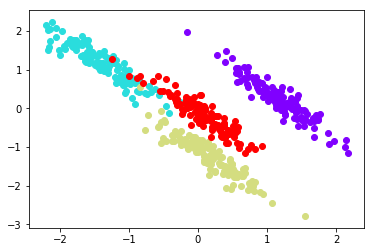

In [11]:
#Visualise the data
colors = cm.rainbow(np.linspace(0, 1, K)) #colours for plotting
for i in range(K):
    plt.scatter(X[labels==i,0], X[labels==i,1], color = colors[i])

### Try various different initial cluster centroid assignments -- it doesn't work!!

No matter how hard we try to make our K-means algorithm work, it just doesn't do a good job in general due to the covariance in the data clusters.

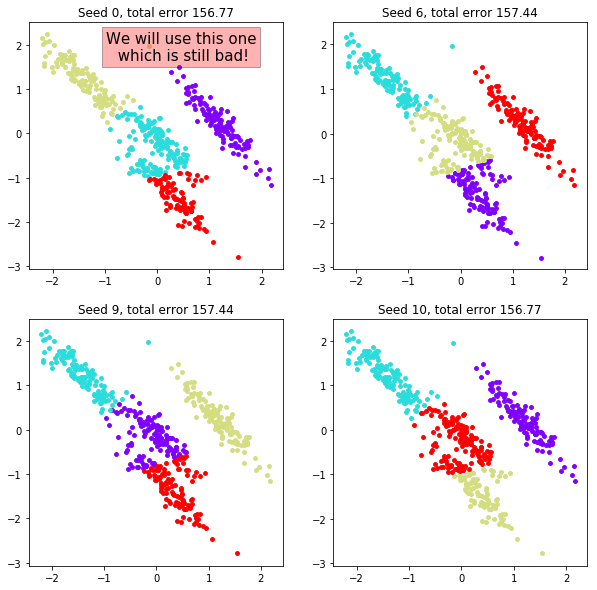

In [12]:
#initialise cluster centres and error values
fig, axs = plt.subplots(2,2, figsize = (10, 10)); axs = axs.ravel()

seeds = [0, 6, 9, 10]
Store_err = np.zeros(len(seeds))

for i, seed in enumerate(seeds):
    #initialise
    np.random.seed(seed)
    clus = InitialiseCentres(K, X)
    [err, err_prev] = [0, 1]

    #The K-means algorithm
    while (not np.isclose(err, err_prev, rtol = 1e-10)):
        err_prev = err
        idx, err = Expectation(X, clus)
        clus = FindCenters(X, idx, K)
    Store_err[i] = err
    
    #show final cluster assignments
    for j in range(K):
        axs[i].scatter(X[j == idx,0], X[j == idx,1], color = colors[j], s = 15)
    axs[i].set_title('Seed %d, total error %.2f' % (seed, err))

axs[np.argmin(Store_err)].text(0.6,0.9, 'We will use this one\n which is still bad!', 
                               horizontalalignment = 'center',
                               verticalalignment = 'center',
                               transform=axs[np.argmin(Store_err)].transAxes,
                               fontsize = 15, bbox=dict(facecolor='red', alpha=0.3))

## 2) Gaussian Mixture Model

**_K-means_**

In K-means clustering we assigned each data point to its closest cluster centroid and said 'this point now belongs to this closest cluster with probability 1'. 

The Expectation step --> returns an array of indices, one index for each datapoint to indicate to which cluster it belongs.

The Maximisation step --> returns the positions of the cluster centroids that minimise our error (the total distance between the data points and their closest cluster centroids)

**_Gaussian Mixture Model (GMM)_**

In a GMM, we don't make such hard statements. Each datapoint has a certain probability to belonging to each cluster. 

The Expectation step --> returns a (m x K) matrix in which each row i gives the probabilities of datapoint i to belong to each of the K clusters. This matrix is called the **responsibility matrix** because it tell us how responsible cluster k is for datapoint i. 

The Maximisation step --> returns the means, covariances and weights of the K clusters that maximise the likelihood of the observed data.  

Like K-means, a GMM can come up with different solutions depending on the initialisation. It is better to run it a few times and pick the solution with the highest likelihood, similar to what we did with K-means above (where we picked the solution with the lowest error).


In [13]:
#initialise
np.random.seed(1)
mu_init = InitialiseCentres(K, X)
pi = [1.0/K]*K
cov_init = [np.identity(X.shape[1])]*K
r_init = Responsibility(X, mu_init, cov_init, pi)

mu = mu_init; cov = cov_init

### Expectation-Maximisation algorithm

In [14]:
#Exp-Max algorithm
nIter = 0
Store_err = np.zeros(60)
llh, llh_prev = [0, 1]

while(not np.isclose(llh, llh_prev, rtol = 1e-3)):
    llh_prev = llh
    
    #Expectation step
    r = Responsibility(X, mu, cov, pi)
    
    #Maximisation step
    pi, mu, cov = Max(r, X)  
    
    #likelihood
    llh = Log_llh(r, X, mu, cov, pi)
    Store_err[nIter] = llh
    
    nIter+= 1
    
print('Needed {} iterations to converge'.format(nIter))

Needed 26 iterations to converge


### Plot results

We now plot the results of the GMM. We provide the contours of the final Gaussian distributions and colour the datapoints in the following way: each datapoint is assigned to the cluster for which it has the highest probability of belonging to. All points belonging to a specific cluster are given the same colour, the intensity depending on the probability of belonging to that cluster. The initial configuration as well as the final result are shown.

The log-likelihood as a function of the number of iterations of the GMM is also shown -- this should be monotonically increasing. 

The final results looks pretty good! Much better than the K-means algorithm

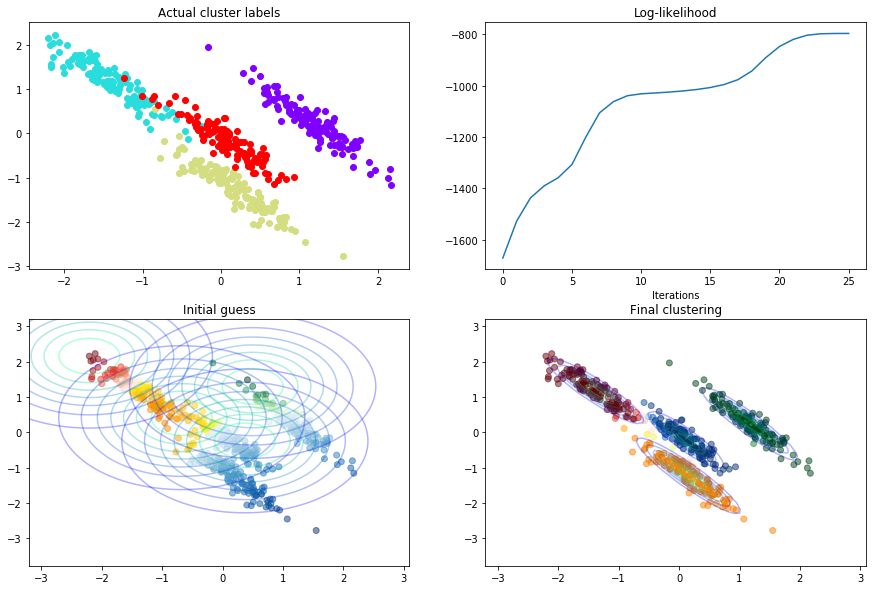

In [15]:
fig, axs = plt.subplots(2,2, figsize = (15, 10)); axs = axs.ravel()
cmaps = ['Reds','Greens','Wistia','Blues']
titles = ['Initial guess', 'Final clustering']

mus = [mu_init, mu]
covs = [cov_init, cov]
rs = [r_init, r]
xmin, ymin = np.min(X, axis = 0)
xmax, ymax = np.max(X, axis = 0)


#actual cluster assignments
for k in range(K):
    axs[0].scatter(X[labels==k,0], X[labels==k,1], color = colors[k])
axs[0].set_title('Actual cluster labels')
    
#likelihood changes throughout iterations
axs[1].plot(np.arange(nIter), Store_err[:nIter])
axs[1].set_title('Log-likelihood')
axs[1].set_xlabel('Iterations')

#plot distributions and data points
idxs = [np.argmax(r_init, axis = 1), np.argmax(r, axis = 1)] #cluster assignments initial guess and final result

for k in range(K):
    for j in range(2):
        #scatter data points
        strs = [str(i) for i in rs[j][k == idxs[j],k]]
        axs[j+2].scatter(X[k == idxs[j],0], X[k == idxs[j],1], c = strs, cmap = cmaps[k], alpha = 0.5)

        #plot contours
        PlotContours(mu = mus[j][k], cov = covs[j][k], X=X, axs = axs[j+2])
        axs[j+2].set_title(titles[j])
                

# Multiple iterations for GMM




Also for the GMM the initialisation of the means and covariance of the base Gaussian distributions can influence the final cluster assignments. Here we repeat the GMM with four different initialisations and plot the final cluster assignments, assuming that each point belongs to the cluster to which it is most likely to belong. 

Like we did for K-means, we choose the configuration with the lowest error (highest log-likelihood).

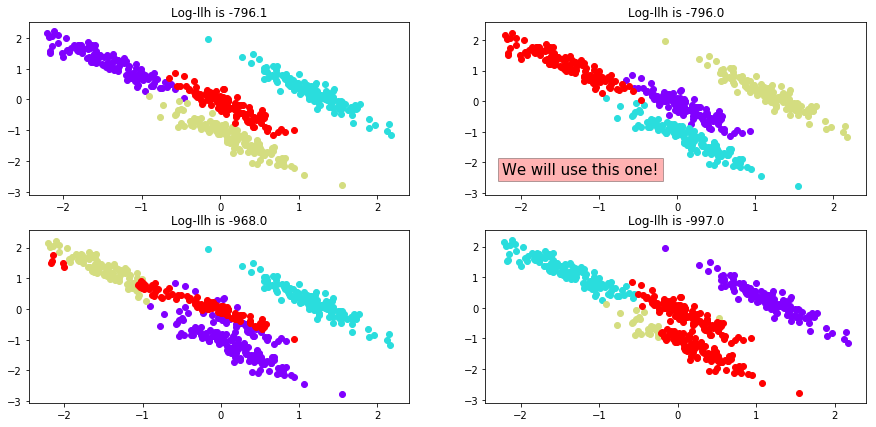

In [16]:
fig, axs = plt.subplots(2,2, figsize = (15, 7)); axs = axs.ravel()
seeds = [1, 2, 3, 10]
Store_err = np.zeros(len(seeds))

for i2, seed in enumerate(seeds):
    #initialise
    np.random.seed(seed)
    mu = InitialiseCentres(K, X)
    pi = [1.0/K]*K
    cov = [np.identity(X.shape[1])]*K
    llh, llh_prev = [0, 1]
    
    #Exp-Max algorithm
    while (not np.isclose(llh, llh_prev, rtol = 1e-3)):
        llh_prev = llh 

        #Expectation step
        r = Responsibility(X, mu, cov, pi)

        #Maximisation step
        pi, mu, cov = Max(r, X)
        
        #likelihood
        llh = Log_llh(r, X, mu, cov, pi)
    Store_err[i2] = llh
        
    #plot
    idxs = np.argmax(r, axis = 1)
    for k in range(K):
        axs[i2].scatter(X[k == idxs,0], X[k == idxs,1], c = colors[k])
    axs[i2].set_title('Log-llh is %.1f' % Store_err[i2])

axs[np.argmax(Store_err)].text(0.25,0.15, 'We will use this one!', 
                       horizontalalignment = 'center',
                       verticalalignment = 'center',
                       transform=axs[np.argmax(Store_err)].transAxes,
                       fontsize = 15, bbox=dict(facecolor='red', alpha=0.3))

### Finally, we'll run it some more times and pick out the best solution

In [26]:
llh_best = -1e8
for i in range(80):
    #initialise
    np.random.seed(i)
    mu = InitialiseCentres(K, X)
    pi = [1.0/K]*K
    cov = [np.identity(X.shape[1])]*K
    llh, llh_prev  = [0, 1]

    #Exp-Max algorithm
    while (not np.isclose(llh, llh_prev, rtol = 1e-3)):
        llh_prev = llh 

        #Expectation step
        r = Responsibility(X, mu, cov, pi)
        
        #Maximisation step
        pi, mu, cov = Max(r, X)

        #likelihood
        llh = Log_llh(r, X, mu, cov, pi)
    #Store best solution
    if llh > llh_best:
        r_best = r
        mu_best = mu
        cov_best = cov
        llh_best = llh

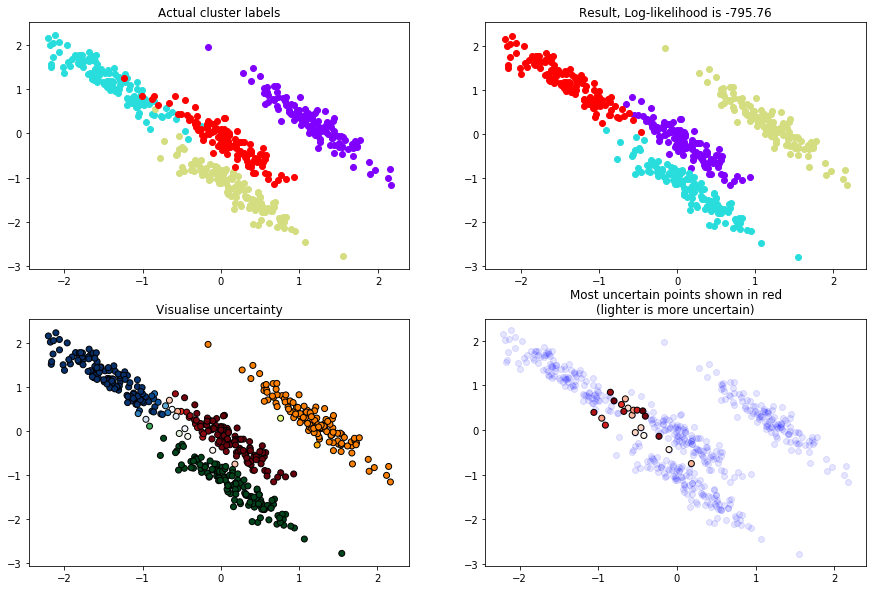

In [27]:
fig, axs = plt.subplots(2,2, figsize = (15,10)); axs = axs.ravel()

#actual cluster assignments
for k in range(K):
    axs[0].scatter(X[labels==k,0], X[labels==k,1], color = colors[k])
axs[0].set_title('Actual cluster labels')

#plot best solution
idxs = np.argmax(r_best, axis = 1)
for k in range(K):
    axs[1].scatter(X[k == idxs,0], X[k == idxs,1], c = colors[k])
    strs = [str(i) for i in r_best[k == idxs,k]]
    axs[2].scatter(X[k == idxs,0], X[k == idxs,1], c = strs, cmap = cmaps[k], edgecolors = 'k')    
    
#points we're most uncertain about to which cluster they belong
prob = r_best[np.arange(X.shape[0]),idxs] #prob of belonging to the most likely cluster
idx_unc = prob.argsort()[:20] #indices of most uncertain points
strs = [str(i) for i in prob[idx_unc]]

axs[3].scatter(X[:,0], X[:,1], color = 'b', alpha = 0.1) #all data in background for reference
axs[3].scatter(X[idx_unc, 0], X[idx_unc, 1], c = strs, cmap = 'Reds', edgecolors = 'k') #uncertain points

axs[1].set_title('Result, Log-likelihood is %.2f' % llh_best)
axs[2].set_title('Visualise uncertainty')
axs[3].set_title('Most uncertain points shown in red\n(lighter is more uncertain)')

When we assign each data point to the cluster to which it is most likely to belong, the algorithm is not 100% correct. This is because it's practically impossible to tell for sure which Gaussian generated a given point when the point lies in a region where two Gaussians overlap. The good thing about this Bayesian approach is that we are aware of not being certain about points in these overlapping regions, as can be seen in the lower two plots.

# GMM for the old faithful dataset

Just because we can, we'll give another example of our GMM model on a different dataset: the old faithful data set which contains eruption durations and eruption waiting times for the old faithful geyser in Yellowstone. We don't really care now what the data exactly means though, we just want to see the clustering

In [11]:
import pandas as pd
data_dir = '../Data/Data_Kmeans/'
data = pd.read_csv('{}faithful.csv'.format(data_dir), delimiter='\t')
X = Norm_data(data.values)

In [12]:
K = 2

In [13]:
#initialise
mu = np.zeros((2,2)); mu[0] = [-1.8, 1.5]; mu[1] = [1.8,-1.5]
pi = [1.0/K]*K
cov = [np.identity(X.shape[1])]*K
llh, llh_prev = [0, 1]
mu_init = mu; cov_init = cov; r_init = Responsibility(X, mu_init, cov_init, pi)

#Exp-Max algorithm
while (not np.isclose(llh, llh_prev, rtol = 1e-3)):
    llh_prev = llh 

    #Expectation step
    r = Responsibility(X, mu, cov, pi)

    #Maximisation step
    pi, mu, cov = Max(r, X)

    #likelihood
    llh = Log_llh(r, X, mu, cov, pi)


### Plot

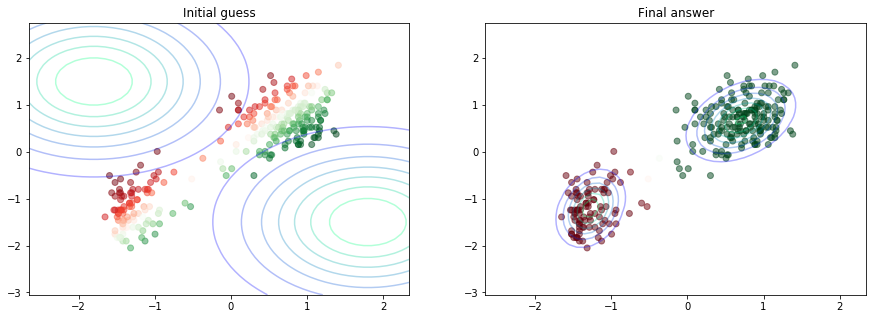

In [14]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5)); axs = axs.ravel()

#divide pars in [initial guess plot, final answer plot]
mus = [mu_init, mu]
covs = [cov_init, cov]
rs = [r_init, r]
idxs = [np.argmax(r_init, axis = 1), np.argmax(r, axis = 1)]
titles = ['Initial guess', 'Final answer']

for j in range(2):
    axs[j].set_title(titles[j])
    for k in range(K):
        strs = [str(i) for i in rs[j][k == idxs[j],k]]
        axs[j].scatter(X[k == idxs[j],0], X[k == idxs[j],1], c = strs, cmap = cmaps[k], alpha = 0.5)
        PlotContours(mu = mus[j][k], cov = covs[j][k], X=X, axs = axs[j])